# Starlink Analysis

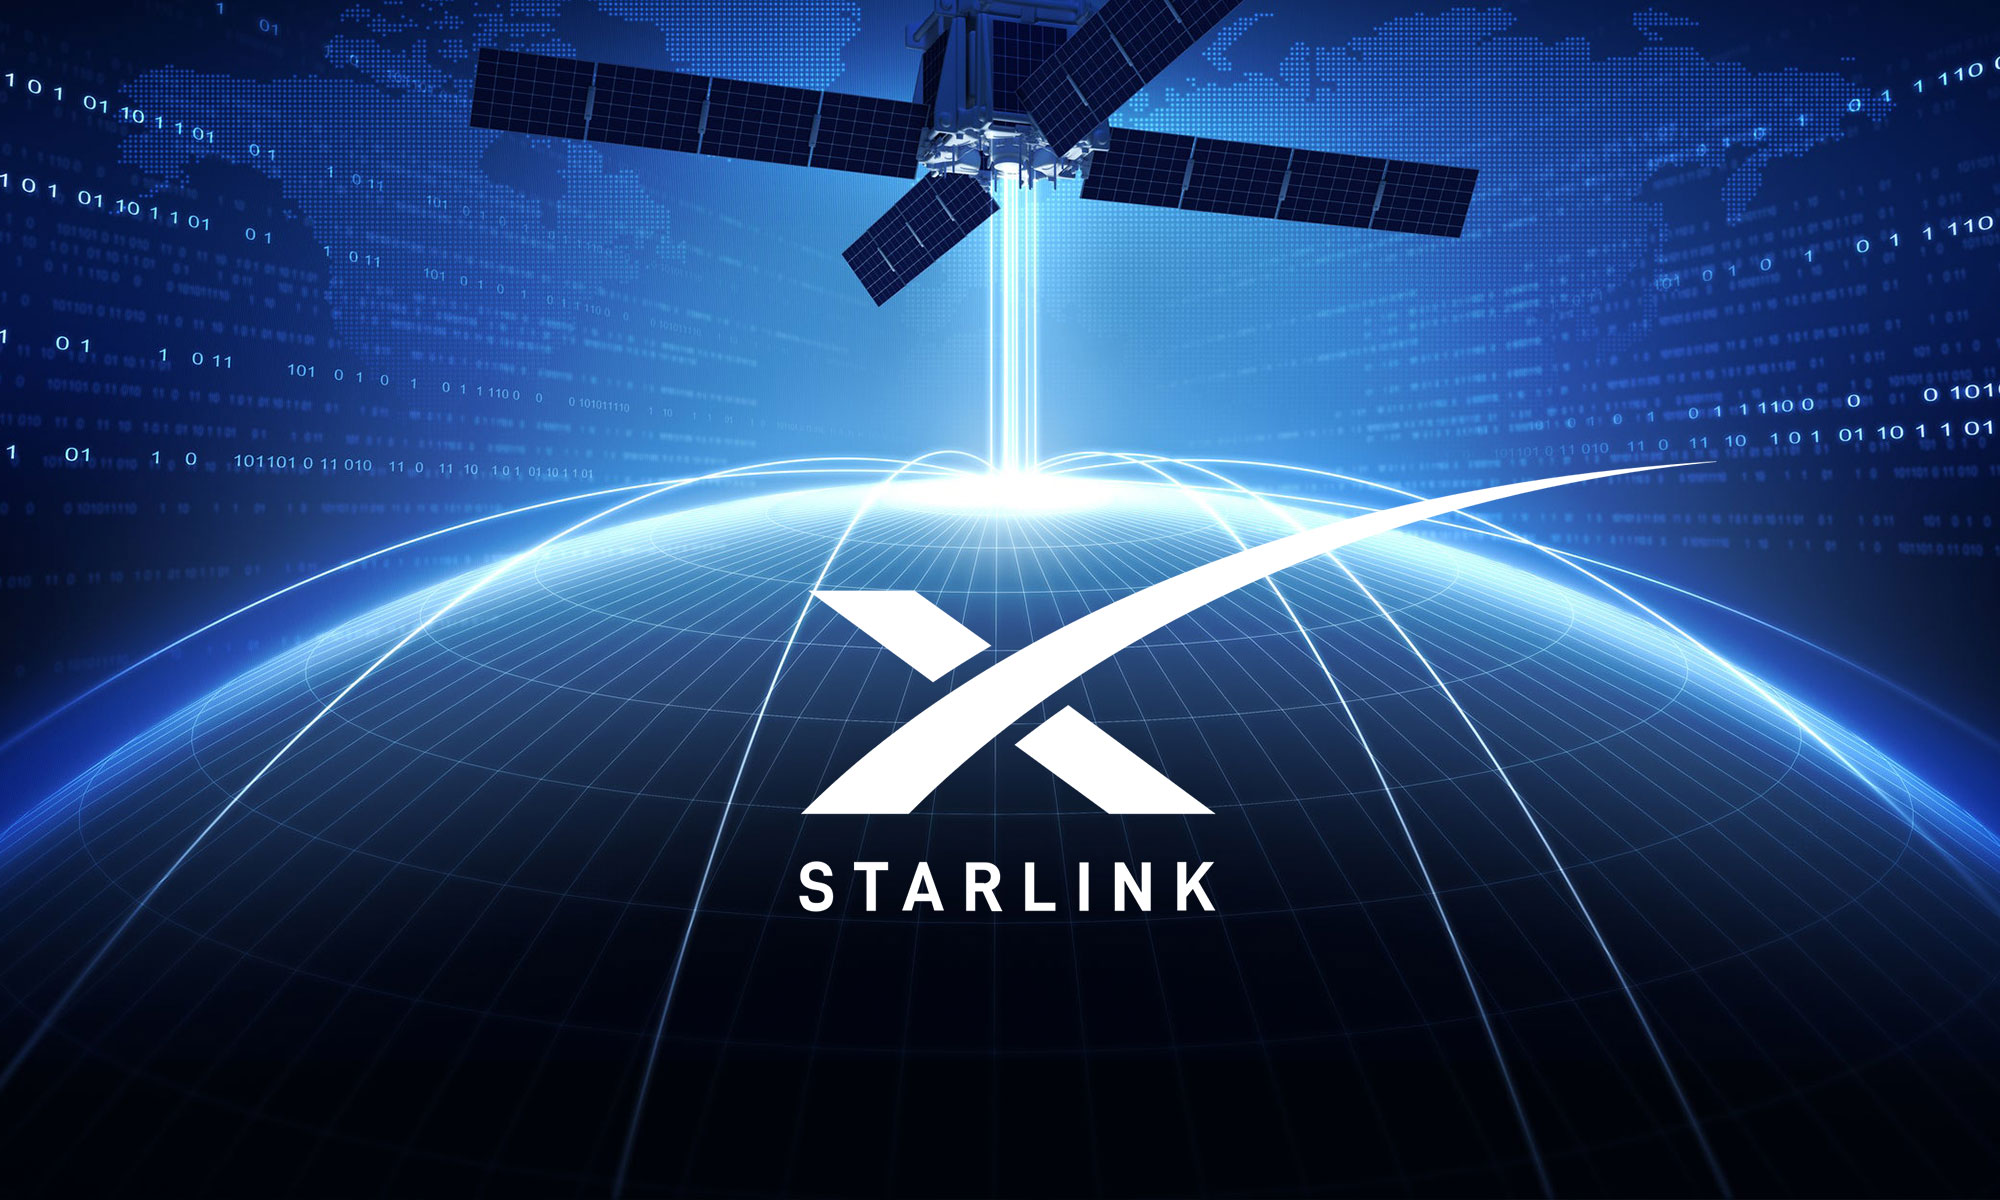

## *What is this project about?*

### **Project Background**
I love the innovation of computer networks because most innovations are based on old ideas but with new technology. In today's world there are several competing network types such as satellite, ethernet and Wi-Fi. This notebook scratches the surface of Starlink - SpaceX's groundbreaking satellite internet constellation.

### **The Question**
How does the performance and reliability of Starlink's Infrastructure compare to traditional network types like ethernet and Wi-Fi?

### **The Data**
The datasets includes performance metrics such as latency, bandwidth, uptime, and signal strength across various locations and conditions for Starlink, ethernet, and Wi-Fi networks. This dataset comprises a collection of measurements from different sources; ethernet and Wi-Fi pull directly from the terminal `traceroute` and `ping` commands while Starlink from custom gRPC scripts. In addition to this, given the variable results yielded by the gRPC scripts, speedtest-cli will also be used to measure the speeds of each network.

### **The Approach**
Our approach begins with a comprehensive Exploratory Data Analysis (EDA) to delve into the intricacies of network performance metrics across ethernet, Wi-Fi and Starlink. Through this exploratory phase, we aim to uncover patterns, understand relationships between variables, and identify key factors influencing network reliability and performance.

### **Hypothesis**
Given Starlink's satellite-based infrastructure and its promise of global coverage, we anticipate that its performance metrics, especially in remote or underserved areas, might differ significantly from traditional ethernet and Wi-Fi networks. We hypothesize that Starlink might exhibit higher latency due to signal transmission via satellites but potentially offer more reliable connectivity in challenging terrains or areas with limited infrastructure.

### **Why Bother?**
![Retransmission-Variance.png](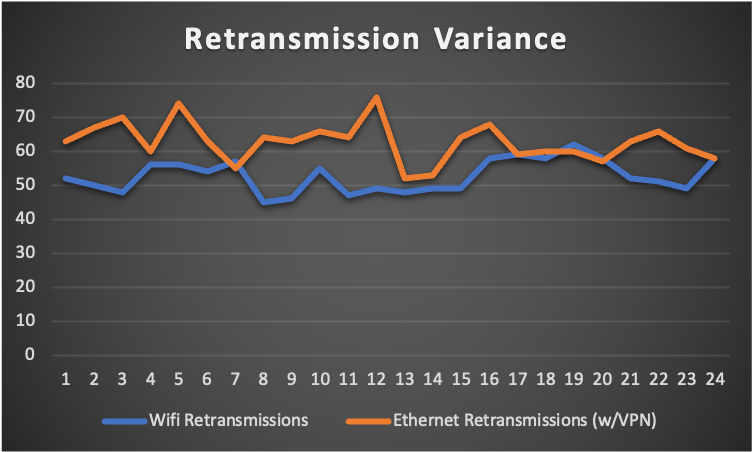![Retransmission-Variance.png](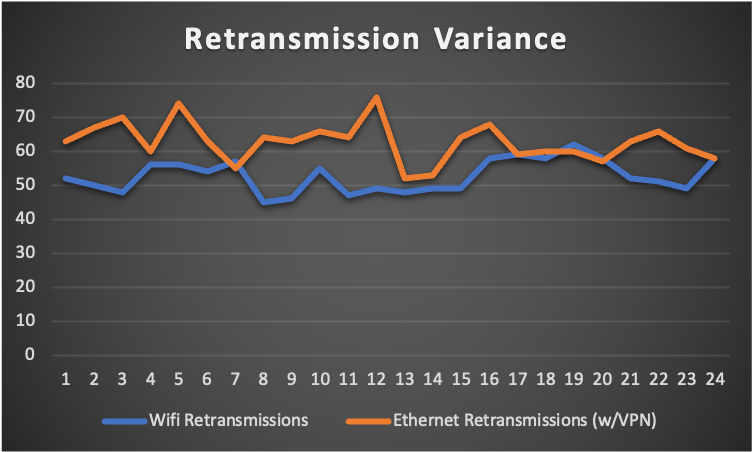![Latency-Variance.png](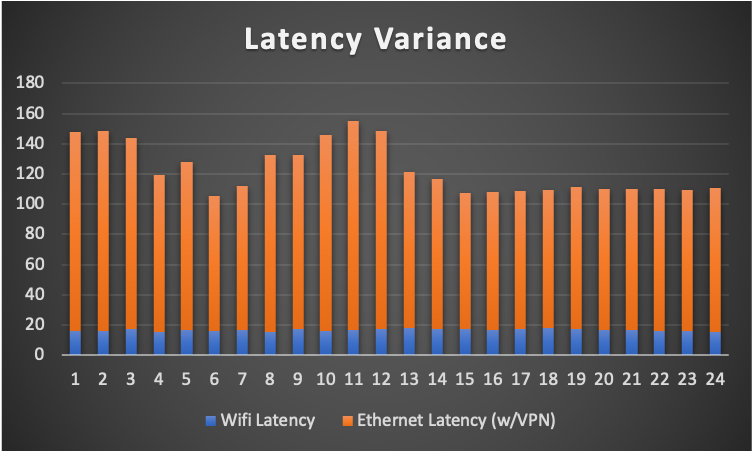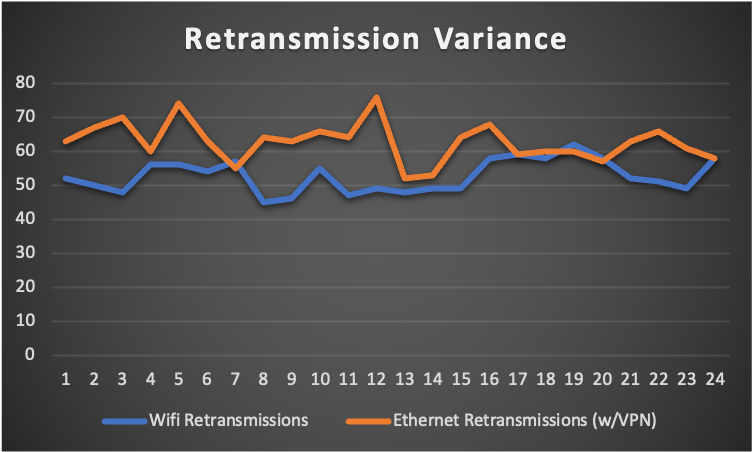)))
Understanding the comparative performance and reliability of different network types is crucial not just for academic interest but also for practical applications. Insights gained from this analysis can inform network deployment strategies, particularly in areas lacking reliable connectivity, aid in optimizing network infrastructure for various use cases, and contribute to the advancement of internet accessibility worldwide.



---



## Library Imports

Below are the libraries that are used in order to perform EDA (Exploratory data analysis) in this project.

In [1]:
# Data retrieval
import pandas as pd
import re

# Computation
import numpy as np

# Visualization
from IPython import display
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

### Mount Google Drive

In [2]:
# Mount Google Drive dir
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data Cleaning

### Convert .txt to dataframe

In [3]:
# Grab the specified file path of combined gRPC Starlink data
file_path = "/content/drive/MyDrive/Starlink Infrastructure Analysis/starlink-combined-data.txt"


def read_file_to_dataframe(file_path):
    # Open the specified file in read mode
    with open(file_path, 'r') as file:
        # Read all lines from the file and store them in a list
        lines = file.readlines()

    # Initialize empty lists and dictionaries
    records = []  # List to store records
    record = {}   # Dictionary to store key-value pairs for each record

    # Iterate through each line in the list of lines
    for line in lines:
        try:
            # Split each line into key and value using colon as a separator
            key, value = line.strip().split(':', 1)

            # Check if the key is 'id' and the record dictionary is not empty
            if key == 'id' and record:
                # Append the current record to the list and reset the record dictionary
                records.append(record)
                record = {}

            # Set the value in the record dictionary
            record[key] = value

            # Append the current record to the list if the record dictionary is not empty
            if record:
                records.append(record)

        except:
            # Ignore any exceptions that occur during line processing
            pass

    # Convert the list of dictionaries into a pandas DataFrame and return it
    return pd.DataFrame(records)



---



### Instantiating Pandas Dataframe

Loading the data into the pandas data frame is certainly one of the most important steps in EDA, as we can see that the value from the data set is comma-separated. So all we have to do is to just read the CSV into a data frame and pandas data frame does the job for us.

To get or load the dataset into the notebook, all I did was one trivial step. In Google Colab at the left-hand side of the notebook, you will find a > (greater than symbol). When you click that you will find a tab with three options, you just have to select Files. Then you can easily upload your file with the help of the Upload option. No need to mount to the google drive or use any specific libraries just upload the data set and your job is done. One thing to remember in this step is that uploaded files will get deleted when this runtime is recycled. This is how I got the data set into the notebook.

In [4]:
gRPC_starlinkData = read_file_to_dataframe(file_path) # Convert txt file to data frame
gRPC_starlinkData.head(5)                             # Display the first 5 rows

,id,hardware_version,software_version,state,uptime,snr,seconds_to_first_nonempty_slot,pop_ping_drop_rate,downlink_throughput_bps,uplink_throughput_bps,...,alert_unexpected_location,alert_slow_ethernet_speeds,alert_roaming,alert_install_pending,alert_is_heating,alert_power_supply_thermal_throttle,alert_is_power_save_idle,alert_moving_while_not_mobile,alert_moving_too_fast_for_policy,alert_dbf_telem_stale
0,ut01000000-00000000-0068a44b,rev3_proto2,bbcabf4d-1c85-49ab-8aba-d257c845ac63.ute...,CONNECTED,3953,,0.0,0.0,13119.783203125,17716.740234375,...,False,False,True,False,False,False,False,False,False,False
1,ut01000000-00000000-0068a44b,rev3_proto2,bbcabf4d-1c85-49ab-8aba-d257c845ac63.ute...,CONNECTED,3953,,0.0,0.0,13119.783203125,17716.740234375,...,False,False,True,False,False,False,False,False,False,False
2,ut01000000-00000000-0068a44b,rev3_proto2,bbcabf4d-1c85-49ab-8aba-d257c845ac63.ute...,CONNECTED,3953,,0.0,0.0,13119.783203125,17716.740234375,...,False,False,True,False,False,False,False,False,False,False
3,ut01000000-00000000-0068a44b,rev3_proto2,bbcabf4d-1c85-49ab-8aba-d257c845ac63.ute...,CONNECTED,3953,,0.0,0.0,13119.783203125,17716.740234375,...,False,False,True,False,False,False,False,False,False,False
4,ut01000000-00000000-0068a44b,rev3_proto2,bbcabf4d-1c85-49ab-8aba-d257c845ac63.ute...,CONNECTED,3953,,0.0,0.0,13119.783203125,17716.740234375,...,False,False,True,False,False,False,False,False,False,False




---



### Dropping irrelevant and insignificant columns

The data collected here is a little bit different. Here’s a snapshot of what the data looks like. Overall the best data we have here is its current state, uptime, up and down speeds, obstruction timeframes, and a lot of alerts flags. Unfortunately, in my experience using this script, these alerts did not help at all. For example, when the speed was slow, the alert_slow_ethernet_speed flag was never procked. You’ll see what I mean here in a second about the speed being slow.

This step is certainly needed in every EDA because sometimes there would be many columns that we never use in such cases dropping is the only solution. In this case, the columns that yield meaningful, measureable results are printed in the dataframe below.

In [5]:
gRPC_starlinkData = gRPC_starlinkData.drop(['id', 'hardware_version', 'software_version', 'state', 'uptime', 'snr', 'seconds_to_first_nonempty_slot', 'seconds_obstructed', 'direction_azimuth', 'direction_elevation', 'is_snr_above_noise_floor', 'wedges_fraction_obstructed', 'raw_wedges_fraction_obstructed', 'valid_s', 'alert_motors_stuck', 'alert_thermal_throttle', 'alert_thermal_shutdown', 'alert_mast_not_near_vertical', 'alert_unexpected_location', 'alert_slow_ethernet_speeds', 'alert_roaming', 'alert_install_pending', 'alert_is_heating', 'alert_power_supply_thermal_throttle', 'alert_is_power_save_idle', 'alert_moving_while_not_mobile', 'alert_moving_too_fast_for_policy', 'alert_dbf_telem_stale'], axis=1)
gRPC_starlinkData.head(5)

,pop_ping_drop_rate,downlink_throughput_bps,uplink_throughput_bps,pop_ping_latency_ms,Alerts bit field,fraction_obstructed,currently_obstructed,obstruction_duration,obstruction_interval
0,0.0,13119.783203125,17716.740234375,115.85713958740234,64,0.01693958230316639,False,2.243499994277954,2541.176513671875
1,0.0,13119.783203125,17716.740234375,115.85713958740234,64,0.01693958230316639,False,2.243499994277954,2541.176513671875
2,0.0,13119.783203125,17716.740234375,115.85713958740234,64,0.01693958230316639,False,2.243499994277954,2541.176513671875
3,0.0,13119.783203125,17716.740234375,115.85713958740234,64,0.01693958230316639,False,2.243499994277954,2541.176513671875
4,0.0,13119.783203125,17716.740234375,115.85713958740234,64,0.01693958230316639,False,2.243499994277954,2541.176513671875


### Datatype Casting

Here we check and convert to the appropriate datatypes from the gRPC script. Given that the output format is .txt, it is guaranteed that Python will not read their datatypes appropriately and will be defaulted to objects. However, this is not feasible for data analysis. After going through the data to verify their appropriate datatypes, we can convert them using the dataframe created above.

In [6]:
# Cast datatypes as numeric types to perform computation
gRPC_starlinkData['pop_ping_drop_rate'] = gRPC_starlinkData['pop_ping_drop_rate'].astype(float)
gRPC_starlinkData['downlink_throughput_bps'] = gRPC_starlinkData['downlink_throughput_bps'].astype(float)
gRPC_starlinkData['uplink_throughput_bps'] = gRPC_starlinkData['uplink_throughput_bps'].astype(float)
gRPC_starlinkData['pop_ping_latency_ms'] = gRPC_starlinkData['pop_ping_latency_ms'].astype(float)
gRPC_starlinkData['Alerts bit field'] = gRPC_starlinkData['Alerts bit field'].astype(int)
gRPC_starlinkData['fraction_obstructed'] = gRPC_starlinkData['fraction_obstructed'].astype(float)
gRPC_starlinkData['currently_obstructed'] = gRPC_starlinkData['currently_obstructed'].astype(bool)
gRPC_starlinkData['obstruction_duration'] = gRPC_starlinkData['obstruction_duration'].astype(float)
gRPC_starlinkData['obstruction_interval'] = gRPC_starlinkData['obstruction_interval'].astype(float)

In [7]:
# Checks data types of each column within the dataframe
gRPC_starlinkData.dtypes

pop_ping_drop_rate         float64
downlink_throughput_bps    float64
uplink_throughput_bps      float64
pop_ping_latency_ms        float64
Alerts bit field             int64
fraction_obstructed        float64
currently_obstructed          bool
obstruction_duration       float64
obstruction_interval       float64
dtype: object



---



### Renaming the columns

In this instance, most of the column names are very confusing to read, so I just tweaked their column names. This is a good approach it improves the readability of the data set.

In [8]:
# Rename the columns to improve readability
gRPC_starlinkData = gRPC_starlinkData.rename(columns={"pop_ping_drop_rate": "Ping Drop Rate", "downlink_throughput_bps": "Downspeed", "uplink_throughput_bps": "Upspeed", "pop_ping_latency_ms": "Latency","fraction_obstructed": "Obstruction", "currently_obstructed": "Obstructed", "obstruction_duration": "Obstruction Duration", "obstruction_interval": "Obstruction Interval" })
gRPC_starlinkData.tail(25) # Display the last 25 entries

,Ping Drop Rate,Downspeed,Upspeed,Latency,Alerts bit field,Obstruction,Obstructed,Obstruction Duration,Obstruction Interval
33507,0.0,42018.539062,10477.371094,32.095238,64,0.055968,True,1.448342,159.409576
33508,0.0,42018.539062,10477.371094,32.095238,64,0.055968,True,1.448342,159.409576
33509,0.0,42018.539062,10477.371094,32.095238,64,0.055968,True,1.448342,159.409576
33510,0.0,42018.539062,10477.371094,32.095238,64,0.055968,True,1.448342,159.409576
33511,0.0,42018.539062,10477.371094,32.095238,64,0.055968,True,1.448342,159.409576
33512,0.0,42018.539062,10477.371094,32.095238,64,0.055968,True,1.448342,159.409576
33513,0.0,42018.539062,10477.371094,32.095238,64,0.055968,True,1.448342,159.409576
33514,0.0,42018.539062,10477.371094,32.095238,64,0.055968,True,1.448342,159.409576
33515,0.0,42018.539062,10477.371094,32.095238,64,0.055968,True,1.448342,159.409576
33516,0.0,42018.539062,10477.371094,32.095238,64,0.055968,True,1.448342,159.409576


In [9]:
# Convert values from bps to Mbps in the DataFrame column
gRPC_starlinkData['Downspeed'] = gRPC_starlinkData['Downspeed'] / 1000000  # Divide by 1,000,000 for conversion from bps to Mbps
gRPC_starlinkData['Upspeed'] = gRPC_starlinkData['Upspeed'] / 1000000  # Divide by 1,000,000 for conversion from bps to Mbps



---



### Dropping the duplicate rows

This is often a handy thing to do because a huge data set as in this case contains more than 10, 000 rows often have some duplicate data which might be disturbing, so here I remove all the duplicate value from the dataset.

In [10]:
gRPC_starlinkData.shape

(33532, 9)

In [11]:
gRPC_starlinkData = gRPC_starlinkData[gRPC_starlinkData.duplicated()]
print("number of duplicate rows: ", gRPC_starlinkData.shape)

number of duplicate rows:  (32650, 9)


Now let us remove the duplicate data because it's ok to remove them.

In [12]:
gRPC_starlinkData.count() # Used to count the number of rows

Ping Drop Rate          32650
Downspeed               32650
Upspeed                 32650
Latency                 32650
Alerts bit field        32650
Obstruction             32650
Obstructed              32650
Obstruction Duration    32650
Obstruction Interval    32650
dtype: int64

In [13]:
gRPC_starlinkData = gRPC_starlinkData.drop_duplicates() # Drop the duplicate entries
gRPC_starlinkData.head(5) # Display the first 5 entries in the dataframe

,Ping Drop Rate,Downspeed,Upspeed,Latency,Alerts bit field,Obstruction,Obstructed,Obstruction Duration,Obstruction Interval
1,0.000000,0.013120,0.017717,115.857140,64,0.016940,True,2.243500,2541.176514
39,0.000000,1.126573,0.046070,29.666666,64,0.016769,True,2.243500,2541.176514
77,0.047619,8.573283,0.121618,37.500000,64,0.017699,True,2.168862,2399.999756
115,0.000000,0.584820,0.020728,28.238094,64,0.017515,True,2.168862,2399.999756
153,0.000000,0.009613,0.009278,31.142857,64,0.017382,True,2.168862,2399.999756


In [14]:
gRPC_starlinkData.count() # Verify the count post duplicate dropping

Ping Drop Rate          882
Downspeed               882
Upspeed                 882
Latency                 882
Alerts bit field        882
Obstruction             882
Obstructed              882
Obstruction Duration    882
Obstruction Interval    882
dtype: int64



---



### Dropping missing, null, N/A values

This is mostly similar to the previous step but in here all the missing values are detected and are dropped later. Now, this is not a good approach to do so, because many people just replace the missing values with the mean or the average of that column, but in this case, I just dropped that missing values. This is because there is nearly 100 missing value compared to 10, 000 values this is a small number and this is negligible so I just dropped those values.

In [15]:
print(gRPC_starlinkData.isnull().sum()) # Verify no null values are present in the dataset

Ping Drop Rate          0
Downspeed               0
Upspeed                 0
Latency                 0
Alerts bit field        0
Obstruction             0
Obstructed              0
Obstruction Duration    0
Obstruction Interval    0
dtype: int64


This is the reason in the above step while counting both Cylinders and Horsepower (HP) had 10856 and 10895 over 10925 rows.

In [16]:
gRPC_starlinkData = gRPC_starlinkData.dropna()    # Dropping the missing values.
gRPC_starlinkData.count()

Ping Drop Rate          882
Downspeed               882
Upspeed                 882
Latency                 882
Alerts bit field        882
Obstruction             882
Obstructed              882
Obstruction Duration    882
Obstruction Interval    882
dtype: int64

To verify, now we have removed all the rows which contain the Null or N/A values.

In [17]:
print(gRPC_starlinkData.isnull().sum())   # After dropping the values

Ping Drop Rate          0
Downspeed               0
Upspeed                 0
Latency                 0
Alerts bit field        0
Obstruction             0
Obstructed              0
Obstruction Duration    0
Obstruction Interval    0
dtype: int64




---



## Data Visualization (Wi-Fi vs Ethernet)

To first measure and compare Wi-Fi and Ethernet, I am utilizing ping and traceroute commands in the terminal to measure overall how reliable and consistent the connections are. Primarily, I am measuring latency, the number of retransmissions and the amount of packet loss each connection has.I wrote python scripts to run both of these commands over a 24-hour period to automate the data collection process.

So let’s jump right in to the performance graphs. So the next three slides I’m going to show the performance between WiFi and Ethernet. The only difference between them is that I made ethernet more of an edge case by using a VPN to really look at each end of the competing networks as best as I could. In terms of the latency between them, there is a drastic difference given that the WiFi network isn’t connected to a VPN whereas the other one is using a VPN.

Here we are looking at the number of retransmissions because of timeouts. The Wi-Fi retransmissions have a minimum of 45, maximum of 62, yielding a variance of 17. Ethernet retransmissions have a minimum of 52, maximum of 72, yielding a variance of 24.

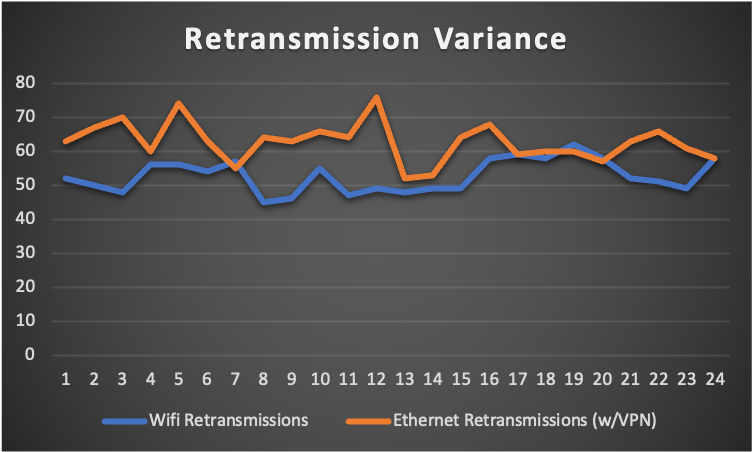

In [18]:
display.Image("/content/drive/MyDrive/Colab Notebooks/Retransmission-Variance.png")

On average, there’s about a 100ms difference between their latencies. However, the latency on ethernet is far more consistent, which is to be expected because it’s hardlined (with a VPN) and not wireless. Overall, this is a clear distinction between an average of 16 versus 106 milliseconds.

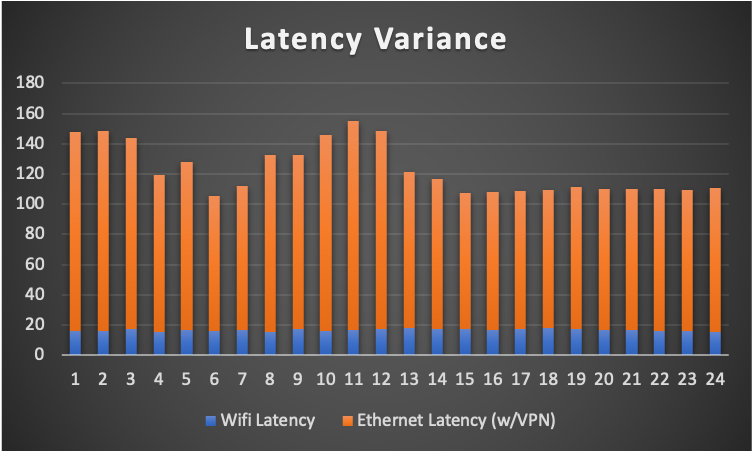

In [19]:
display.Image("/content/drive/MyDrive/Colab Notebooks/Latency-Variance.png")

This last graph between wireless and hardlined connections paint a picture we all can recognize. My network at home is providing a 500/500 Mbps connection, which is basically shown here with the ethernet connection steadily pacing around 500 Mbps and the Wi-Fi is usually about half of that speed, showing a fluctuation between 200 and 300 Mbps. The numbers here also fortify that by showing the average being about half of the provided hardline speed and the ethernet connection sits pretty close to the speed I pay for.

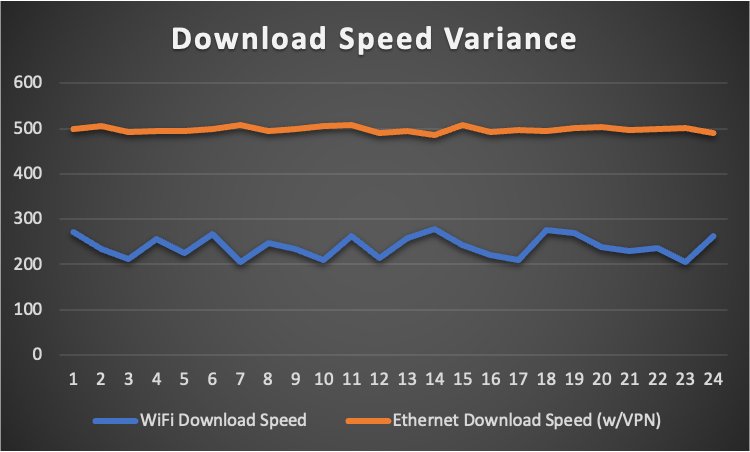

In [20]:
display.Image("/content/drive/MyDrive/Colab Notebooks/Download-Variance.png")

Alright, so now that those have been shown and compared, let’s dive right into Starlink.

## Data Visualization (gRPC data)

Starlink was quite interesting to work with. Initially, out of curiosity, I wanted to try to see if the same commands for my network at home worked with Starlink but that didn’t work. Because of this, I found a repo on GitHub with gRPC script for Starlink that can collect data from the dish. gRPC is just Google’s version of RPC which can call functions in other systems as if they’re local, which is pretty efficient and secure.

Regarding data collection, there were two initial attempts made to work with the Starlink hardware. Initially, only gRPC scripts were running to scrape and collect data from the Starlink hardware. Said scripts establish connections between endpoints to evaluate data transfer which measures throughput by sending data continuously or in bursts, resembling a speedtest-like saturation to assess network capacity. Unfortunately, after extensive testing, the gRPC script approach did not yield the results desired. Thus, the speedtest tools were heavily relied upon to initiate connections to dedicated servers and continuously sending data until the network channel reached its threshold.

To specify what data the gRPC script pulled from the hardware, here is a comprehensive list of its data: [hardware] id, hardware version, software version, [connection] state, uptime, snr, seconds to first nonempty slot, pop ping drop rate, down-link \& up-link throughput (bps), pop ping latency (ms), alerts bit field, fraction obstructed, currently obstructed, seconds obstructed, obstruction duration \& interval, direction azimuth \& elevation, is snr above noise floor, and many alert flags for stuck motors, thermal throttling, thermal shutdown, if the mast is not vertical, unexpected location, slow ethernet speeds, roaming, pending [update] install, is overheating, is in power-saving mode or idle, moving while not mobile, moving too fast for policy and if the digital beam forming (dbf) is stale.

Here we visualize the data collected from the gRPC script used in this [GitHub repo](https://github.com/sparky8512/starlink-grpc-tools).

#### **Latency**
Here is a birds-eye view of the overall latency before spearheading latency data from the gRPC script.

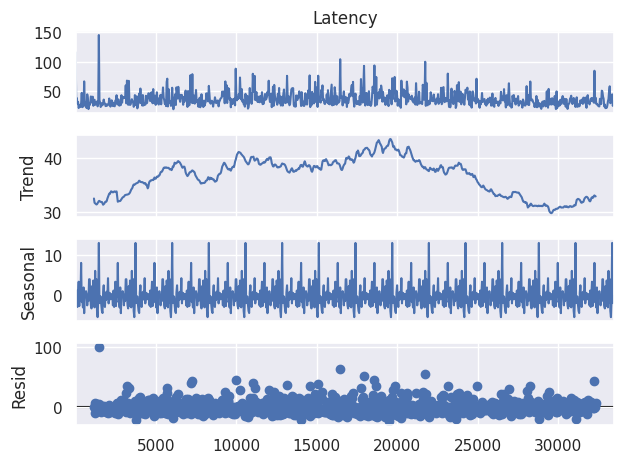

In [21]:
# Assuming a single column for decomposition
decomposition = seasonal_decompose(gRPC_starlinkData['Latency'], model='additive', period=60)
decomposition.plot()
plt.show()

This graph shows its overall latency over time. Since the full 24 hours wasn’t measured, I left the axis to be iterations over time, which is about 60 iterations per minute. Overall its latency has a pretty big variance between 18 and 145. So, if you’re gaming and heavily rely on ping, Starlink may not be for you.

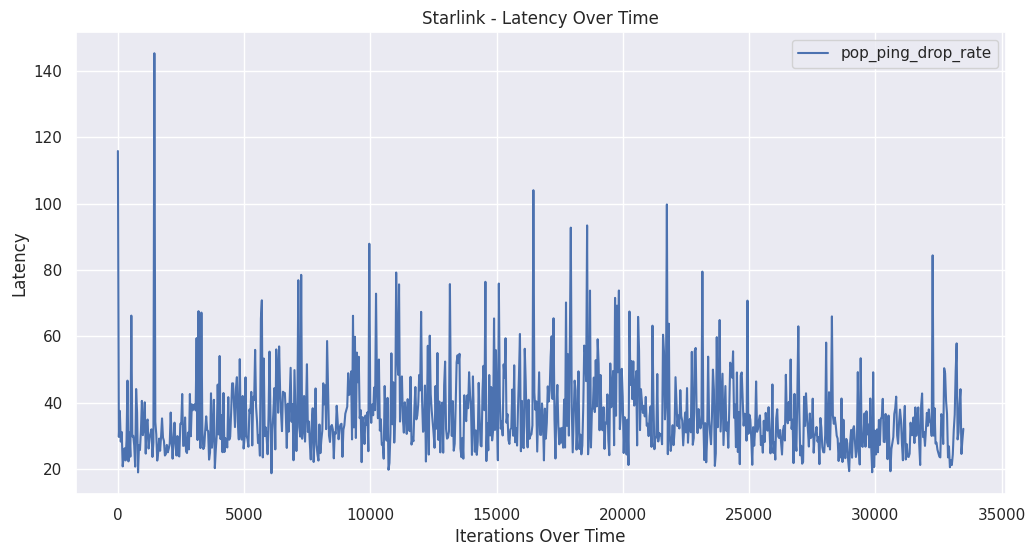

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(gRPC_starlinkData['Latency'], label='pop_ping_drop_rate')
plt.title('Starlink - Latency Over Time')
plt.xlabel('Iterations Over Time')
plt.ylabel('Latency')
plt.legend()
plt.show()

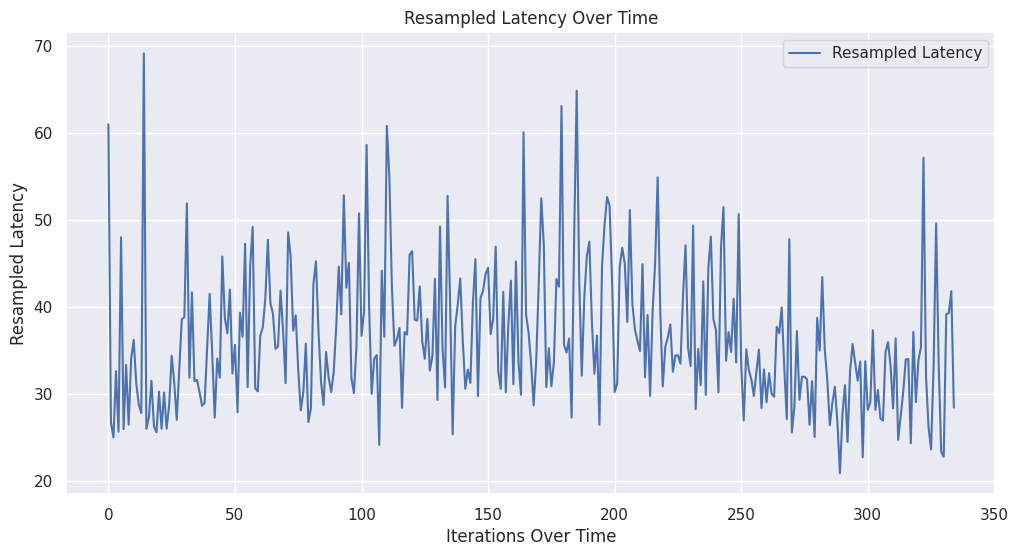

In [23]:
# Resampling data to intervals (e.g., every 100 data points)
interval_size = 100
resampled_data = gRPC_starlinkData.groupby(gRPC_starlinkData.index // interval_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(resampled_data.index, resampled_data['Latency'], label='Resampled Latency')
plt.title('Resampled Latency Over Time')
plt.xlabel('Iterations Over Time')
plt.ylabel('Resampled Latency')
plt.legend()
plt.show()

The window here indicates that there are about 60 iterations per minute, the number of data points in each calculation. The rolling mean is also known as the moving average. The size of the window here scales with how long-term the trend you’re looking at is.

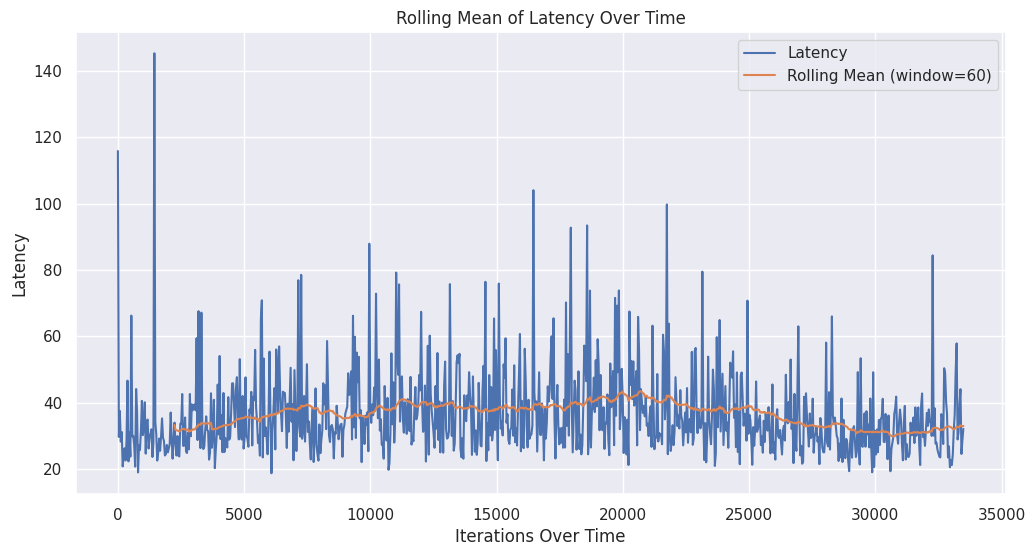

In [24]:
rolling_mean = gRPC_starlinkData['Latency'].rolling(window=60).mean()  # Assuming a window of 60 data points

plt.figure(figsize=(12, 6))
plt.plot(gRPC_starlinkData.index, gRPC_starlinkData['Latency'], label='Latency')
plt.plot(gRPC_starlinkData.index, rolling_mean, label='Rolling Mean (window=60)')
plt.title('Rolling Mean of Latency Over Time')
plt.xlabel('Iterations Over Time')
plt.ylabel('Latency')
plt.legend()
plt.show()

#### **Obstruction**

Here's where things get interesting. I presume that during the initial setup of Starlink, it may have run into obstructions on my balcony, working around nearby trees, the roof, or things of that nature. Afterwards, the obstruction timeframe quickly drops off and doesn’t really spike much at all – maybe things flying through the sky, weather change (because it has been rainy and cloudy as well), there could be a lot of factors at play here. Despite these conditions, it perseveres pretty well overall in terms of working in an ideal setting. Starlink was setup where there was more than 180 degrees of clear sky visible.

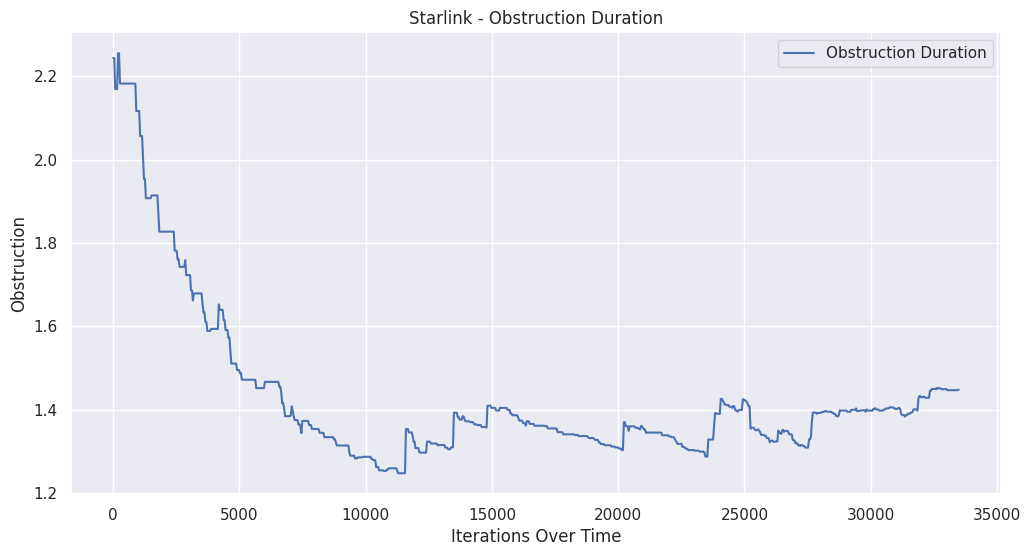

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(gRPC_starlinkData['Obstruction Duration'], label='Obstruction Duration')
plt.title('Starlink - Obstruction Duration')
plt.xlabel('Iterations Over Time')
plt.ylabel('Obstruction')
plt.legend()
plt.show()

In [26]:
# Convert values from bps to Mbps in the DataFrame column
gRPC_starlinkData['Downspeed'] = gRPC_starlinkData['Downspeed'] / 1_000_000  # Divide by 1,000,000 for conversion to Mbps
gRPC_starlinkData['Upspeed'] = gRPC_starlinkData['Upspeed'] / 1_000_000  # Divide by 1,000,000 for conversion to Mbps

#### **Download Speed**

And, boom, this is a big blow to the Starlink’s performance. It’s maximum download speed is 8.57 Mbps, with an average of 0.1 Mbps. I found this to be very odd because when I initially used it on campus, its speed fluctuated A LOT but still was within a reasonable range. My sample data was between 8Mbps and 50Mbps with some minor obstructions on the balcony of Winston Chung Hall. But, I didn’t use this script – I was testing the speeds with speedtest.net.

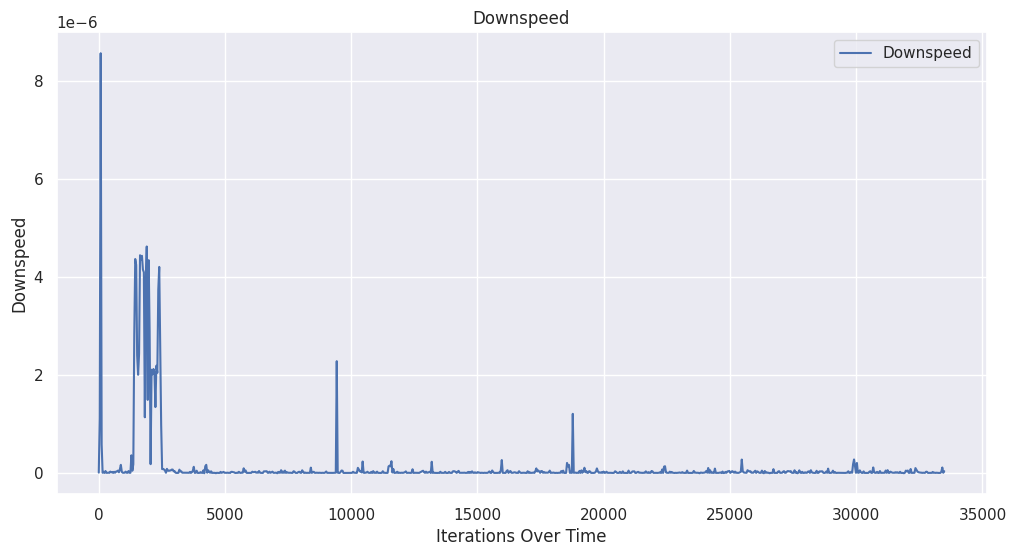

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(gRPC_starlinkData['Downspeed'], label='Downspeed')
# Add other columns as needed
plt.title('Downspeed')
plt.xlabel('Iterations Over Time')
plt.ylabel('Downspeed')
plt.legend()
plt.show()

In [28]:
print("Starlink Download min:", gRPC_starlinkData['Downspeed'].min())
print("Starlink Download max:", gRPC_starlinkData['Downspeed'].max())
print("Starlink Download avg:", gRPC_starlinkData['Downspeed'].mean())

Starlink Download min: 0.0
Starlink Download max: 8.573283e-06
Starlink Download avg: 1.3404818726139545e-07


#### **Upload Speed**

Since we already saw how bad the download speed was, we already know the upload is going to be worse. Its max was only about 5Mbps with an average of just under 0.1 Mbps. Clearly these are not fully indicative of Starlink's performance capabilities.

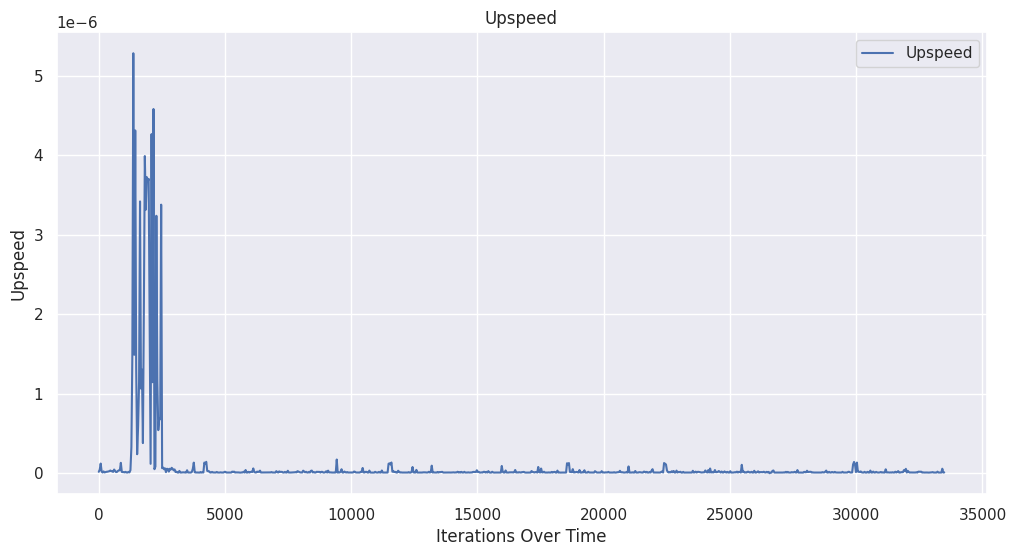

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(gRPC_starlinkData['Upspeed'], label='Upspeed')
# Add other columns as needed
plt.title('Upspeed')
plt.xlabel('Iterations Over Time')
plt.ylabel('Upspeed')
plt.legend()
plt.show()

In [30]:
print("Starlink Upspeed min:", gRPC_starlinkData['Upspeed'].min())
print("Starlink Upspeed max:", gRPC_starlinkData['Upspeed'].max())
print("Starlink Upload avg:", gRPC_starlinkData['Upspeed'].mean())

Starlink Upspeed min: 0.0
Starlink Upspeed max: 5.281518e-06
Starlink Upload avg: 9.04923467439059e-08


The main challenges with this project were trying to, firstly, setup Starlink because it did not like any obstructions at all when initially setting it up. The major challenge was data collection. Because Starlink’s API is no longer available to the public, there are a limited amount of tools available to analyze the network, so the scope of the project was refined to what I’m presenting tonight. Given that the tunneling of Starlink is inherently private and proprietary, it limits the end-user’s visibility and overall access to network data analytics.

## Data Visualization (SpeedTest)
Here we can test against the gRPC scripts by using [Speedtest](https://speedtest.net).

Regarding the observation of small throughput when using the gRPC scripts, it could indeed relate to how these scripts are designed. If they are not saturating the channel as aggressively as traditional speedtest tools, it could explain the difference in observed throughput values. To ensure a fair comparison, it's essential to incorporate both methodologies when testing Starlink or any network. Using gRPC scripts provides insights into how the network handles specific types of data transfer or communication patterns, while speedtest tools assess the maximum achievable throughput under a sustained load scenario. By integrating both approaches, the evaluation becomes more comprehensive, capturing different aspects of network behavior. It's crucial to understand the nuances of each method and interpret the results considering their specific testing strategies and objectives.

In [31]:
file_path = "/content/drive/MyDrive/Colab Notebooks/Starlink_SpeedTest_Results.txt"

parsed_data = []

with open(file_path, 'r') as file:
    for line in file:
        numbers = re.findall(r'\d+\.\d+|\d+', line)
        if len(numbers) == 4:
            parsed_result = int(numbers[0]), float(numbers[1]), float(numbers[2]), float(numbers[3])
            parsed_data.append(parsed_result)

df_starlinkSpeedTest = pd.DataFrame(parsed_data, columns=['Minute', 'DownloadSpeed', 'UploadSpeed', 'Ping'])

In [32]:
print(df_starlinkSpeedTest.head()) # Display the first 5 entries

   Minute  DownloadSpeed  UploadSpeed    Ping
0       1      13.462108    17.786003  50.610
1       2      83.668959     9.484121  36.585
2       3      73.804883    18.988577  47.965
3       4      80.894442    23.335981  40.724
4       5      70.464152    20.050862  46.689


In [33]:
# Summary statistics
summary = df_starlinkSpeedTest.describe()
print(summary)

            Minute  DownloadSpeed  UploadSpeed         Ping
count  1422.000000    1422.000000  1422.000000  1422.000000
mean    723.095640      55.574941    12.711575    46.675902
std     416.446869      23.393331     6.808834    13.561170
min       1.000000       0.156168     0.000000    23.015000
25%     365.250000      37.219573     7.803536    38.091000
50%     725.500000      58.590458    11.749131    43.465500
75%    1083.750000      76.379410    16.428252    51.042500
max    1440.000000      92.267451    43.909502   162.736000




---



### **Overall Data Relationships**

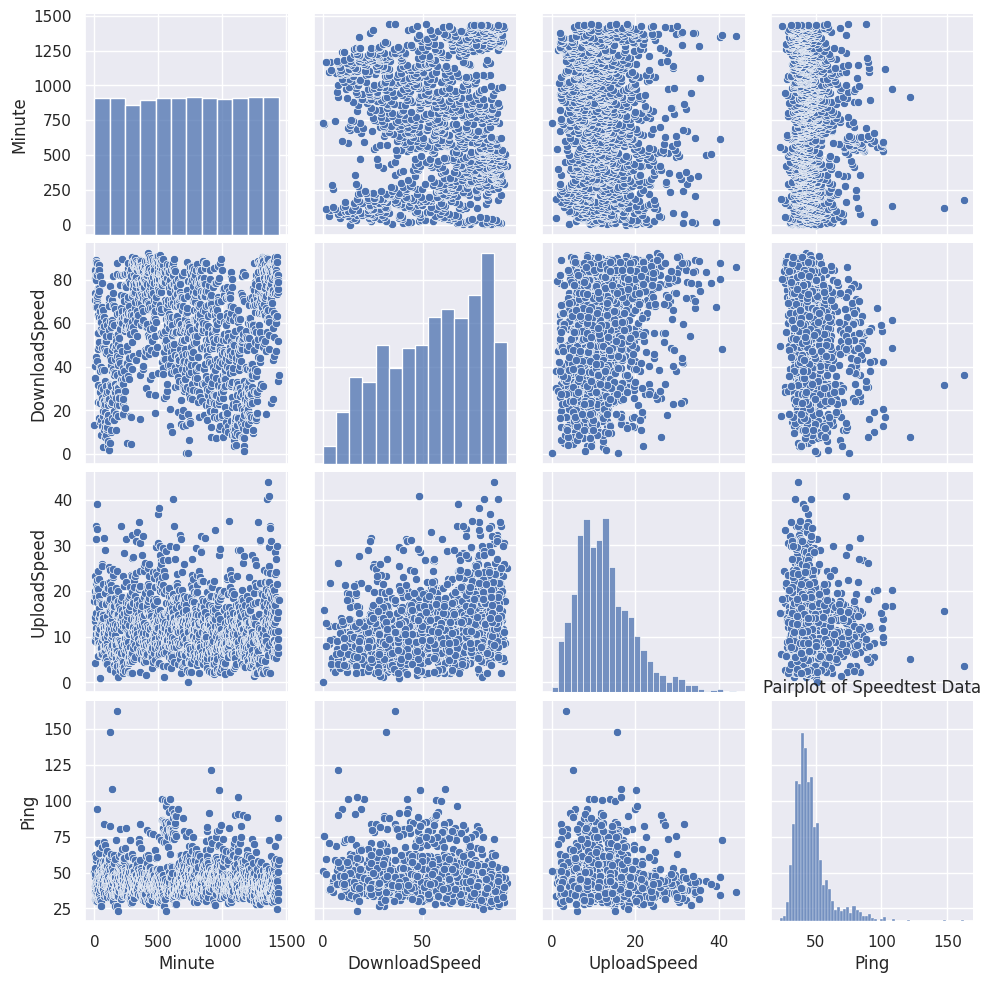

In [34]:
# Pairplot for visualizing relationships
sns.pairplot(df_starlinkSpeedTest)
plt.title('Pairplot of Speedtest Data')
plt.show()

### **Line Plot of Download and Upload Speeds over Time**
Visualizing the trend of download and upload speeds across time (minutes) can reveal patterns or fluctuations. This line plot can help identify any noticeable trends, such as speed variations during specific time intervals. Here, the dotted lines denote the averages amongst the fluctuating speeds.

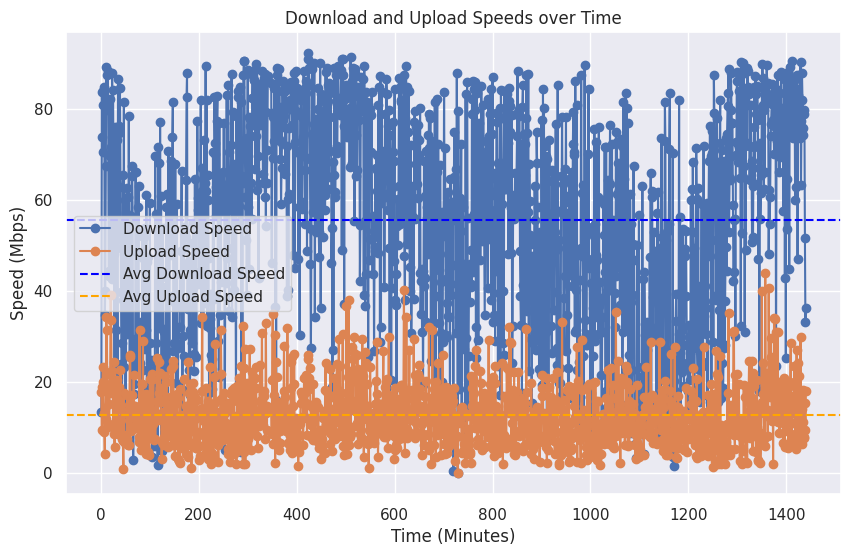

In [35]:
plt.figure(figsize=(10, 6))

plt.plot(df_starlinkSpeedTest['Minute'], df_starlinkSpeedTest['DownloadSpeed'], marker='o', label='Download Speed')
plt.plot(df_starlinkSpeedTest['Minute'], df_starlinkSpeedTest['UploadSpeed'], marker='o', label='Upload Speed')

# Adding average lines
plt.axhline(y=55.574941, color='blue', linestyle='--', label='Avg Download Speed')
plt.axhline(y=12.711575, color='orange', linestyle='--', label='Avg Upload Speed')


plt.xlabel('Time (Minutes)')
plt.ylabel('Speed (Mbps)')
plt.title('Download and Upload Speeds over Time')
plt.legend()
plt.grid(True)
plt.show()

### **Histogram**

Histogram refers to the frequency of occurrence of variables in an interval. Histograms display the distribution of values within each variable, offering insights into the frequency or density of different speed or ping values. Here we can notice the significant difference in upload and download speed compared to before.

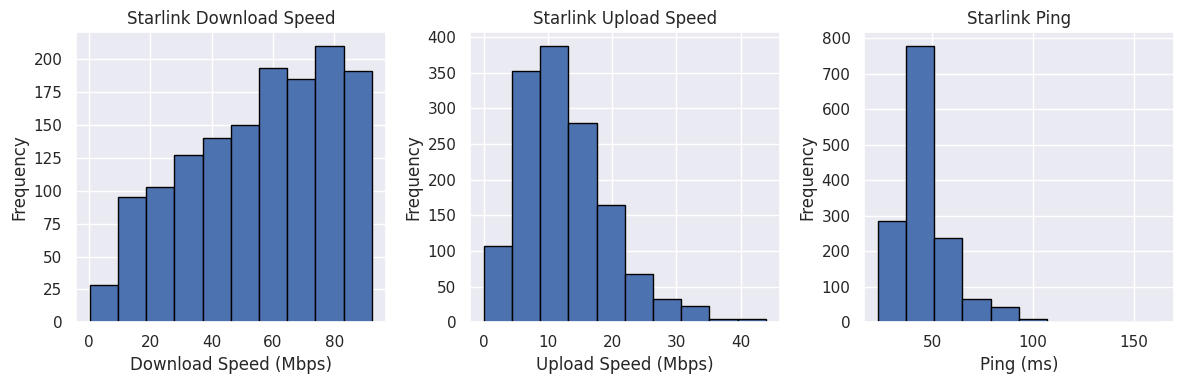

In [36]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(df_starlinkSpeedTest['DownloadSpeed'], bins=10, edgecolor='black')
plt.title('Starlink Download Speed')
plt.xlabel('Download Speed (Mbps)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(df_starlinkSpeedTest['UploadSpeed'], bins=10, edgecolor='black')
plt.title('Starlink Upload Speed')
plt.xlabel('Upload Speed (Mbps)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(df_starlinkSpeedTest['Ping'], bins=10, edgecolor='black')
plt.title('Starlink Ping')
plt.xlabel('Ping (ms)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

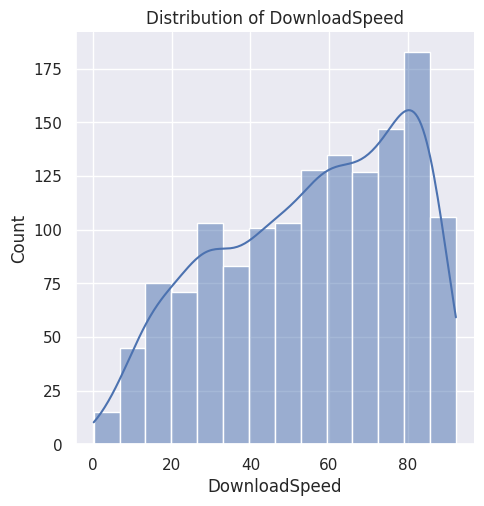

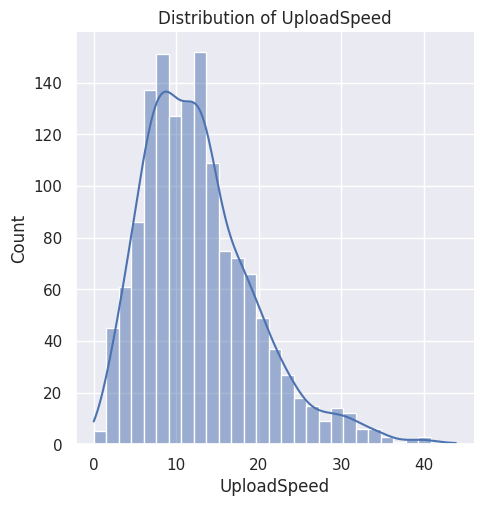

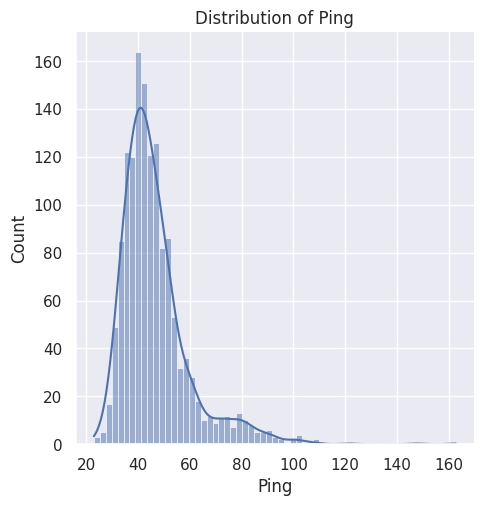

In [37]:
# Distribution plot for each column
for col in df_starlinkSpeedTest.columns[1:]:
    sns.displot(df_starlinkSpeedTest[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

###**Violin Plot**
Violin plots combine boxplots with the kernel density estimation to showcase the distribution of speeds, displaying both the summary statistics and the probability density.

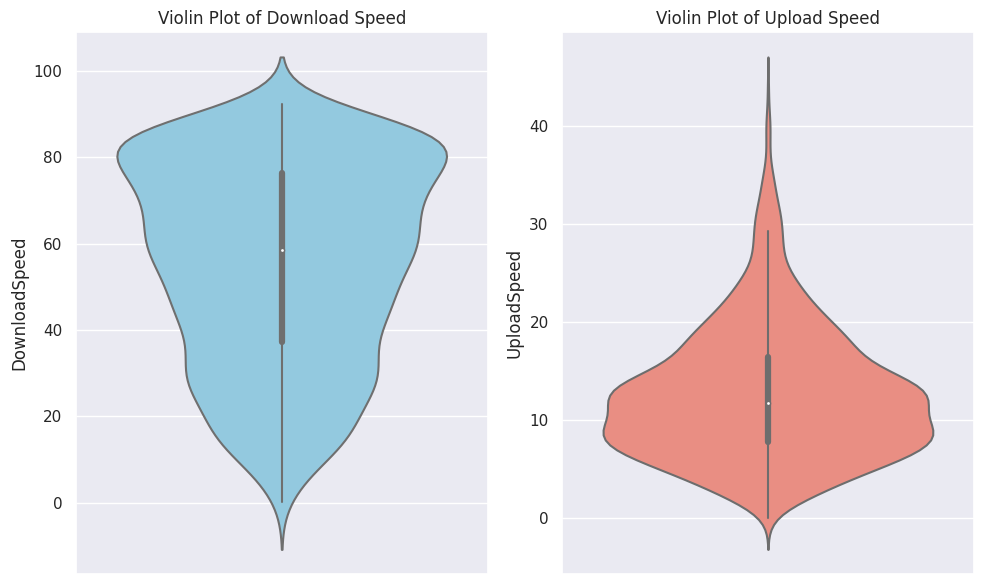

In [38]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.violinplot(y=df_starlinkSpeedTest['DownloadSpeed'], color='skyblue')
plt.title('Violin Plot of Download Speed')

plt.subplot(1, 2, 2)
sns.violinplot(y=df_starlinkSpeedTest['UploadSpeed'], color='salmon')
plt.title('Violin Plot of Upload Speed')

plt.tight_layout()
plt.show()

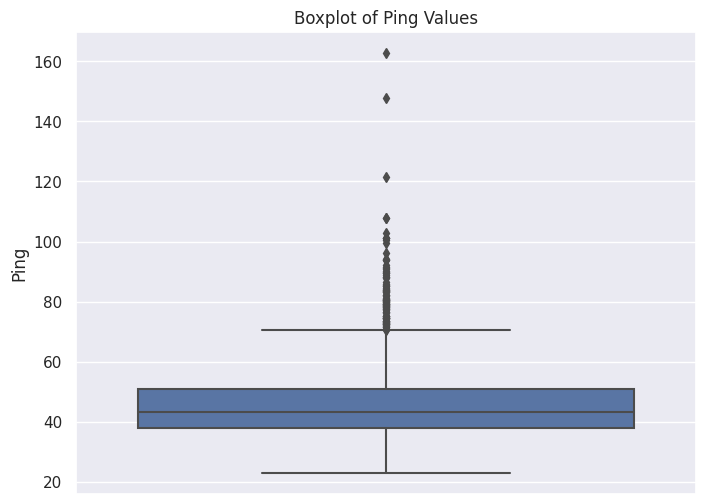

In [39]:
plt.figure(figsize=(8, 6))

sns.boxplot(y=df_starlinkSpeedTest['Ping'])
plt.title('Boxplot of Ping Values')
plt.ylabel('Ping')
plt.show()

### **Boxplot for Ping Values**
A boxplot can help visualize the distribution of ping values and identify outliers or variations in latency. This is crucial as ping directly affects network responsiveness. This clearly shows the outliers of ping values and the cluster of values between 70 and 100.

## Concluding Thoughts

Here, we will briefly assess if this product is accessible from a consumer standpoint, conclude our findings and look at future work potential.

### **Product Accessibility**

Here we question if Starlink is a viable solution with respect to financial and environmental factors. Overall, Starlink is designed to be relatively easy to setup. Starlink comes equipped with a self-aligning dish and a user-friendly setup/install kit that does not require technical expertise. As Starlink's goal is to emphasize its accessibility around the world, its installation essentially requires either a clear view of the sky to establish and maintain a consistent connection; if this is not possible, it must be mounted to a roof or in similar fashion to ensure such connection. To shed light on Starlink's scope of requirements, an average user must ensure that Starlink's surroundings have clear visibility of the sky with minimal to no obstructions. From this, its usability must consider if this is possible if the Starlink hardware is mounted to a roof or in a similar fashion. However, the upfront and overhead costs seem to clearly outweigh its competitors when compared side-by-side. Starlink's base hardware package costs about \$500 USD which does not include its \$120 per month service subscription. Compared to the average internet service providers (ISPs) today, do not charge for hardware and the price can range from as low as \$30 USD per month to \$100+ USD per month depending on speed threshold guarantees. It is imperative to note here that Starlink does not guarantee such speeds as current ISPs offer. Overall, when comparing Starlink to current ISP offerings, Starlink has more cost overhead, reliability overhead and requires additional setup steps.

### **Conclusion**
In conclusion, this comprehensive investigation illuminated substantial nuances in the reliability and performance attributes across WiFi, Ethernet, and Starlink networks. The discerned variations underscore the criticality of tailored network selection based on specific user contexts and scenarios. Forthcoming endeavors will delve into the nuanced impacts on specific applications, integrate predictive machine learning models for network behavior, and encompass emerging network technologies, fostering a deeper understanding within the evolving network landscape. Performance-wise, Starlink's performance in this test environment proves its worthiness as competition to WiFi but does not come close to Ethernet speed and reliability. Compared to every-day options with Ethernet and WiFi, given my current internet package of 500 Mbps, it costs about 30\% less than Starlink without considering its hardware cost overhead.

### **Future Work**
Moving forward, the next steps are to work with different third-party script variants to measure Starlink's performance in several different types of environments (e.g., partially-enclosed, completely open, ideal environment, densely-populated cities with compact buildings, etc.). If the Starlink API becomes publicly accessible, further insight could be used to gain insight on its proprietary tunneling and pathing. This experiment only sheds light on the surface of Starlink's performance compared to solidified modernized solutions and does not show Starlink in its best light possible. However, given its rising popularity and extensive funding, Starlink may overtake ISPs we know today.